In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
chrs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(f'Vocab size: {vocab_size}')

Vocab size: 27


In [5]:
block_size = 3

def build_dataset(ds):
    X, Y = [], []

    for word in ds:
        context = [0] * block_size
        for ch in word + '.':
            chi = stoi[ch]
            X.append(context)
            Y.append(chi)
            context = context[1:] + [chi]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# splitting
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size) ** 0.5)
# b1 = torch.randnd(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

In [7]:
# batchnorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

In [8]:
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [43]:
# training
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X and Y

    # forward pass
    emb = C[Xb] # (32,3,10)
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors (32, 30)
    # Linear layer
    hpreact = embcat @ W1 # hidden layer
    # BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # tracking stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2818
  10000/ 200000: 2.5072
  20000/ 200000: 1.9667
  30000/ 200000: 2.2004
  40000/ 200000: 2.3555
  50000/ 200000: 2.0405
  60000/ 200000: 2.1505
  70000/ 200000: 2.1268
  80000/ 200000: 1.9924
  90000/ 200000: 2.1514
 100000/ 200000: 2.2821
 110000/ 200000: 2.0132
 120000/ 200000: 2.1632
 130000/ 200000: 2.1568
 140000/ 200000: 1.5929
 150000/ 200000: 2.0797
 160000/ 200000: 1.9312
 170000/ 200000: 2.0286
 180000/ 200000: 2.1115
 190000/ 200000: 1.8280


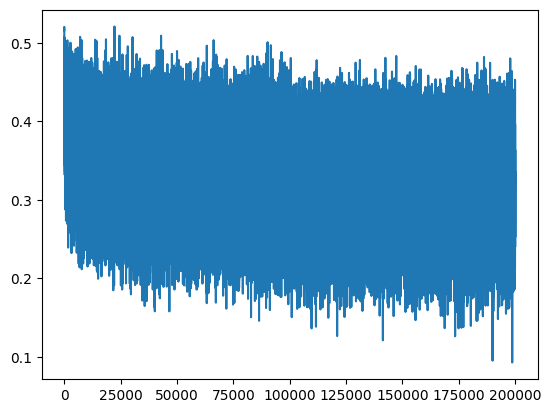

In [44]:
plt.plot(lossi)

In [ ]:
# calibrating batch norm at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    # measuring through entire training
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [45]:
# evaluation
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0651562213897705
val 2.1168432235717773


# Torch-alike code

In [17]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True): # in_features, out_features, bias
        self.w = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5 # improving input data
        self.b = torch.randn(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.w] + ([] if self.b is None else [self.b])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-05, momentum=0.1): # num_features, eps=1e-05, momentum=0.1
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # updating buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [18]:
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 100 # number of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # make last layer less confident
    layers[-1].gamma *= 0.1
    # apply gain to all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.w *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'Total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

Total parameters: 47024


In [20]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update:data ratio

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concat
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

   # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # tracking stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break
    

      0/ 200000: 3.2912


In [26]:
# evalutaion
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

for layer in layers:
    layer.training = False # putting layers into eval mode
split_loss('train')
split_loss('val')

train 2.4264776706695557
val 2.424229621887207


In [28]:
# sampling from model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[x] for x in out))

carpah.
qarlilvif.
jmrri.
thty.
sacansa.
jazhntefapliah.
jagqeiu.
ramara.
chriiv.
kalein.
dhlm.
join.
qhijthn.
lilea.
jadbq.
wazerogdearyxi.
jaheininsan.
ed.
ecoia.
gtleley.


# Visualising

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.38%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.34%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.19%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.12%


Text(0.5, 1.0, 'activation distribution')

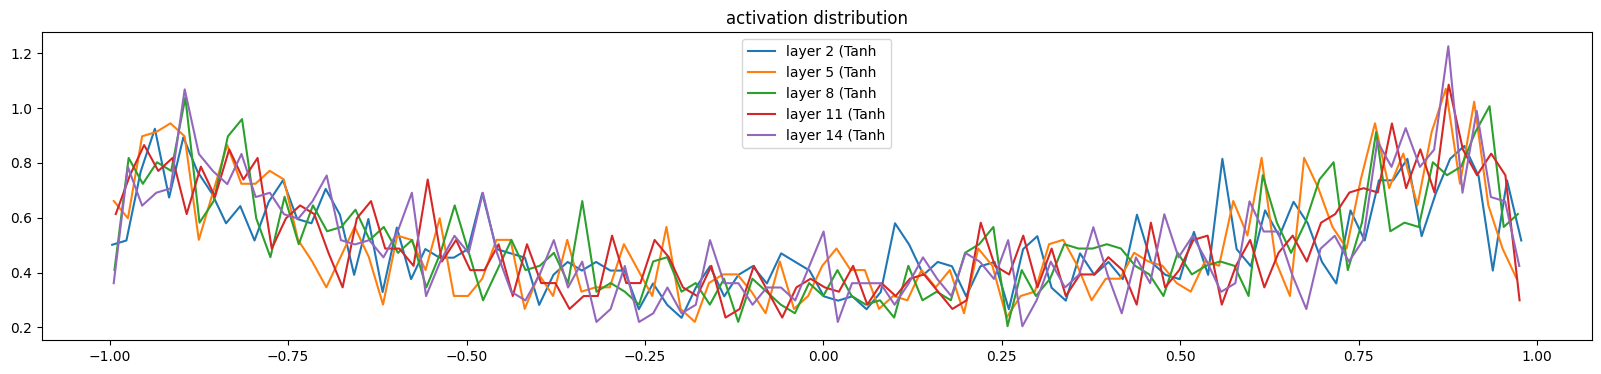

In [21]:
# activation distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.608869e-03
layer 5 (      Tanh): mean +0.000000, std 3.159967e-03
layer 8 (      Tanh): mean -0.000000, std 2.929565e-03
layer 11 (      Tanh): mean +0.000000, std 2.603785e-03
layer 14 (      Tanh): mean +0.000000, std 2.479880e-03


Text(0.5, 1.0, 'gradient distribution')

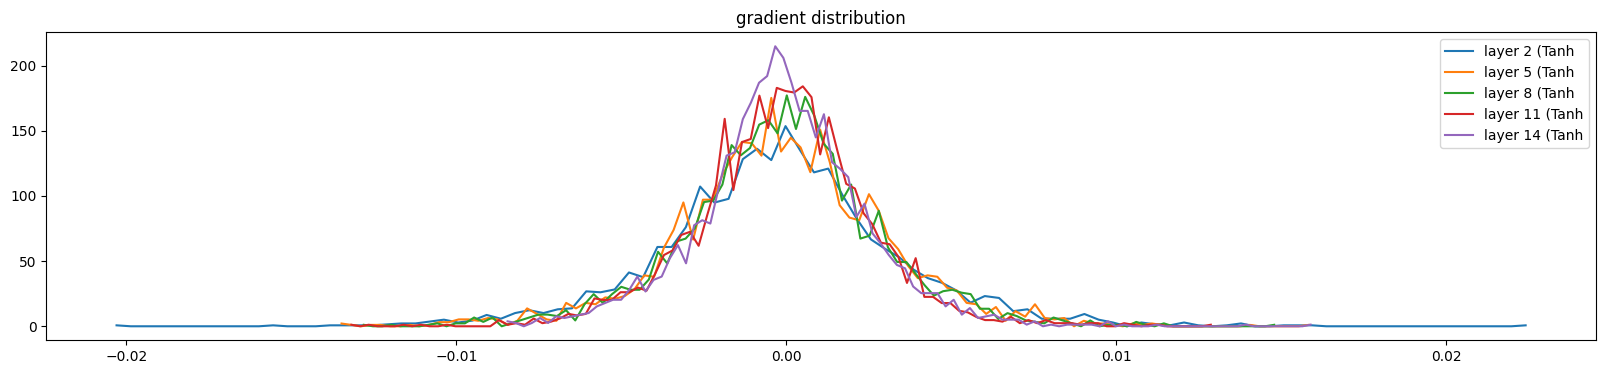

In [22]:
# gradient distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.336582e-03 | grad:data ratio 8.328081e-03
weight  (30, 100) | mean -0.000199 | std 7.748297e-03 | grad:data ratio 2.479034e-02
weight (100, 100) | mean -0.000097 | std 6.289240e-03 | grad:data ratio 3.761749e-02
weight (100, 100) | mean +0.000023 | std 5.647909e-03 | grad:data ratio 3.348607e-02
weight (100, 100) | mean +0.000011 | std 5.280172e-03 | grad:data ratio 3.145623e-02
weight (100, 100) | mean +0.000031 | std 4.860224e-03 | grad:data ratio 2.894860e-02
weight  (100, 27) | mean +0.000032 | std 9.558162e-03 | grad:data ratio 5.734780e-02


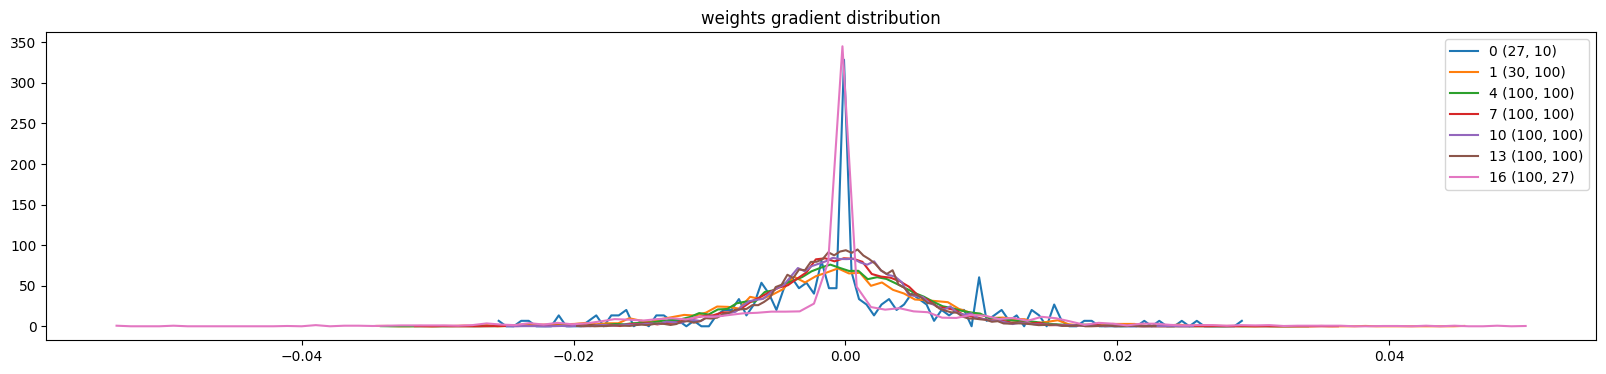

In [23]:
# weights gradient distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

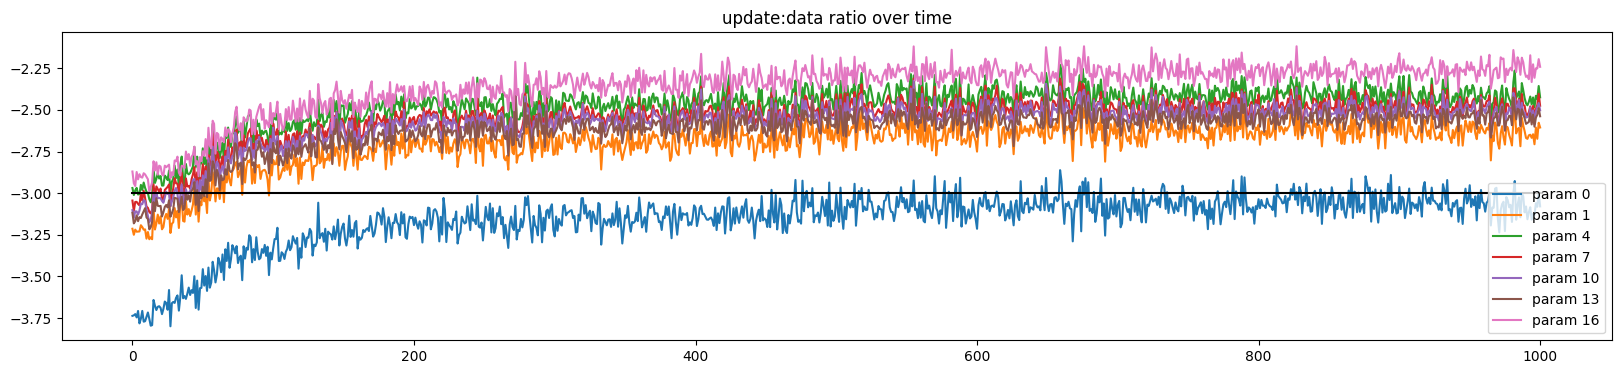

In [25]:
# update:data ratio over time
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title('update:data ratio over time');